# Import and Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

In [2]:
# read data
df_music = pd.read_csv('five_k.csv')

# some cleaning
df_music = df_music.replace(r"^ +| +$", r"", regex=True)
df_music = df_music.rename(columns=lambda x: x.strip())

# drop useless cols
df_music = df_music.drop(columns=['Unnamed: 0', 'duration_ms', 'type', 'id', 'html'])
df_music.head(8)

# drop duplicate rows
#df_music.duplicated().value_counts()
df_music = df_music.drop_duplicates()

In [3]:
df_music.describe()

danceability       energy          key     loudness         mode  \
count   5164.000000  5164.000000  5164.000000  5164.000000  5164.000000   
mean       0.507494     0.653254     5.263555    -9.379017     0.647366   
std        0.218142     0.289502     3.572071     6.316775     0.477836   
min        0.000000     0.000000     0.000000   -60.000000     0.000000   
25%        0.306000     0.475000     2.000000   -11.385250     0.000000   
50%        0.536000     0.738000     5.000000    -7.361500     1.000000   
75%        0.686000     0.895000     8.000000    -5.297500     1.000000   
max        0.967000     1.000000    11.000000     1.342000     1.000000   

       speechiness  acousticness  instrumentalness     liveness      valence  \
count  5164.000000   5164.000000       5164.000000  5164.000000  5164.000000   
mean      0.083137      0.291425          0.260512     0.185539     0.442185   
std       0.070968      0.356872          0.371906     0.149653     0.277946   
min       0.000000      0.000000          0.000000     0.000000     0.000000   
25%       0.038900      0.002270          0.000001     0.092500     0.195000   
50%       0.055700      0.096200          0.002210     0.125000     0.414000   
75%       0.098800      0.570250          0.657250     0.237000     0.676000   
max       0.918000      0.996000          0.985000     0.987000     0.985000   

             tempo  time_signature  
count  5164.000000     5164.000000  
mean    118.657748        3.901627  
std      28.597810        0.422133  
min       0.000000        0.000000  
25%      96.069750        4.000000  
50%     119.011500        4.000000  
75%     134.038250        4.000000  
max     213.990000        5.000000

In [4]:
def filter_outliers(df, col_list):
    for col in col_list:#metrics:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df = df.loc[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
        return df

df_music = filter_outliers(df_music, ['speechiness', 'loudness', 'tempo'])

In [5]:
df_music.describe()

danceability       energy          key     loudness         mode  \
count   4733.000000  4733.000000  4733.000000  4733.000000  4733.000000   
mean       0.500837     0.641658     5.249313    -9.659994     0.651173   
std        0.215020     0.294959     3.562680     6.475155     0.476650   
min        0.000000     0.000000     0.000000   -60.000000     0.000000   
25%        0.304000     0.451000     2.000000   -11.773000     0.000000   
50%        0.528000     0.729000     5.000000    -7.613000     1.000000   
75%        0.675000     0.890000     8.000000    -5.390000     1.000000   
max        0.967000     1.000000    11.000000     1.342000     1.000000   

       speechiness  acousticness  instrumentalness     liveness      valence  \
count  4733.000000   4733.000000       4733.000000  4733.000000  4733.000000   
mean      0.065995      0.304556          0.272668     0.183398     0.438528   
std       0.037584      0.364968          0.377145     0.146634     0.278197   
min       0.000000      0.000000          0.000000     0.000000     0.000000   
25%       0.037900      0.002320          0.000002     0.092600     0.194000   
50%       0.051600      0.103000          0.003550     0.124000     0.402000   
75%       0.084000      0.623000          0.703000     0.233000     0.673000   
max       0.188000      0.996000          0.985000     0.987000     0.985000   

             tempo  time_signature  
count  4733.000000     4733.000000  
mean    118.401558        3.896049  
std      27.980695        0.430469  
min       0.000000        0.000000  
25%      96.814000        4.000000  
50%     119.427000        4.000000  
75%     133.450000        4.000000  
max     213.990000        5.000000

# Split data

in two dfs, one containing text info (title, interpreter, etc.) and another one with useful numerical data

In [6]:
metrics = ['danceability', 'energy', 
           'key',
           'loudness', 
           'mode', 
           'speechiness', 
           'acousticness', 'instrumentalness', 
           'liveness', 
           'valence', 'tempo', #'time_signature'
          ]

In [7]:
df_general = df_music.loc[:, ~df_music.columns.isin(metrics)].copy()
df = df_music.loc[:, df_music.columns.isin(metrics)].copy()

#df_general.head()
#df.head()

In [8]:
#df.describe()

# Data scaling

In [9]:
# Initialise the transformer (optionally, set parameters)
min_max = MinMaxScaler().set_output(transform="pandas")

# Use the transformer to transform the data
scaled_df = min_max.fit_transform(df)
scaled_df.head()

danceability  energy       key  loudness  mode  speechiness  acousticness  \
0      0.680455  0.2590  1.000000  0.763897   0.0     0.375000      0.696787   
1      0.767322  0.3990  0.181818  0.771967   1.0     0.184043      0.217871   
3      0.729059  0.0502  0.363636  0.682811   1.0     0.250532      0.882530   
4      0.673216  0.1190  0.545455  0.655228   1.0     0.202128      0.919679   
5      0.481903  0.1460  0.272727  0.692837   1.0     0.345213      0.934739   

   instrumentalness  liveness   valence     tempo  
0          0.000060  0.987842  0.310660  0.515800  
1          0.000002  0.108409  0.703553  0.584322  
3          0.000041  0.391084  0.531980  0.499098  
4          0.000348  0.105370  0.408122  0.565171  
5          0.156345  0.108409  0.429442  0.667718

In [10]:
scaled_df.describe()

danceability       energy          key     loudness         mode  \
count   4733.000000  4733.000000  4733.000000  4733.000000  4733.000000   
mean       0.517929     0.641658     0.477210     0.820645     0.651173   
std        0.222358     0.294959     0.323880     0.105558     0.476650   
min        0.000000     0.000000     0.000000     0.000000     0.000000   
25%        0.314374     0.451000     0.181818     0.786199     0.000000   
50%        0.546019     0.729000     0.454545     0.854015     1.000000   
75%        0.698035     0.890000     0.727273     0.890255     1.000000   
max        1.000000     1.000000     1.000000     1.000000     1.000000   

       speechiness  acousticness  instrumentalness     liveness      valence  \
count  4733.000000   4733.000000       4733.000000  4733.000000  4733.000000   
mean      0.351037      0.305779          0.276820     0.185814     0.445206   
std       0.199915      0.366433          0.382888     0.148566     0.282433   
min       0.000000      0.000000          0.000000     0.000000     0.000000   
25%       0.201596      0.002329          0.000002     0.093820     0.196954   
50%       0.274468      0.103414          0.003604     0.125633     0.408122   
75%       0.446809      0.625502          0.713706     0.236069     0.683249   
max       1.000000      1.000000          1.000000     1.000000     1.000000   

             tempo  
count  4733.000000  
mean      0.553304  
std       0.130757  
min       0.000000  
25%       0.452423  
50%       0.558096  
75%       0.623627  
max       1.000000

In [11]:
### Alternative scaling
# Number of samples
#number_of_samples = df.shape[0]

# Create a QuantileTransformer object
#quant_trans = QuantileTransformer(n_quantiles = number_of_samples).set_output(transform="pandas")

# Transform the DataFrame
#scaled_df2 = quant_trans.fit_transform(df)

#scaled_df2.describe()

# Exploratory clustering

Perform first round of clustering to identify the main distinctive variables and define the major clusters.

In [12]:
wcss = []
clusters = []
silhouettes = []

for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, 
                    #init='random',
                    init='k-means++',
                    n_init=10,
                    #n_init='auto',
                    max_iter=300,
                    random_state=101)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(scaled_df, kmeans.labels_))
    clusters.append(k)
    #print(kmeans.n_iter_)

#print(clusters, wcss)

In [13]:
slope = np.diff(wcss)
curve = np.diff(slope)
elbow = np.argmax(curve) + 1
print(clusters[elbow])

3


Text(0, 0.5, 'silhouette score')

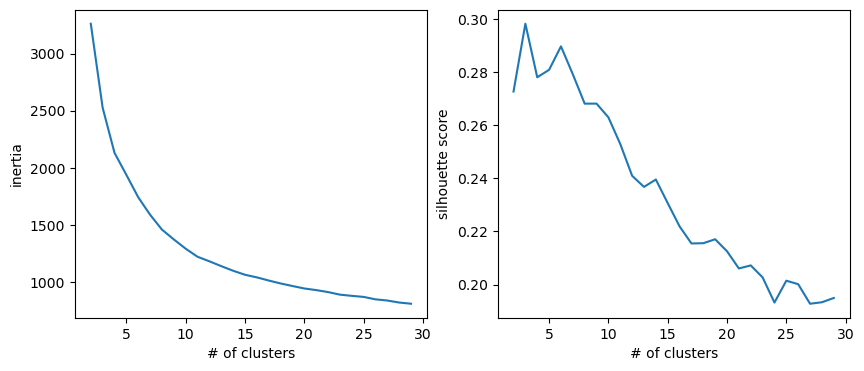

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(clusters, wcss)
axs[0].set_xlabel('# of clusters')
axs[0].set_ylabel('inertia')

axs[1].plot(clusters, silhouettes)
axs[1].set_xlabel('# of clusters')
axs[1].set_ylabel('silhouette score')

Text(0, 0.5, 'inertia curvature')

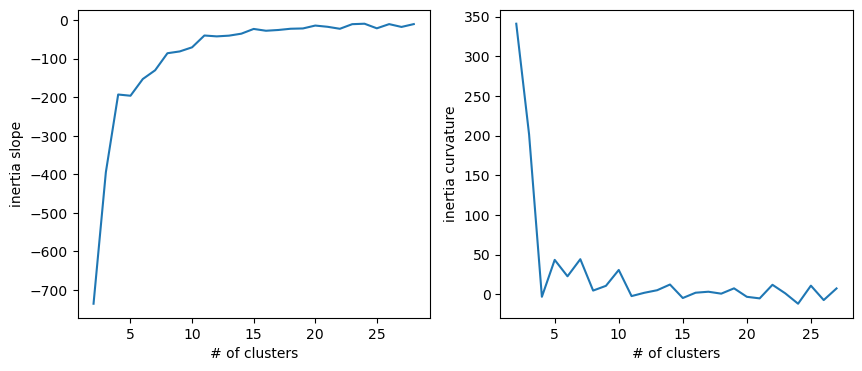

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(clusters[:-1], slope)
axs[0].set_xlabel('# of clusters')
axs[0].set_ylabel('inertia slope')

axs[1].plot(clusters[:-2], curve)
axs[1].set_xlabel('# of clusters')
axs[1].set_ylabel('inertia curvature')

In [16]:
random_state = 101

# Initialise the model
kmeans = KMeans(n_clusters = 5, 
                n_init = "auto",
                random_state = random_state)

# Fit the model to the data
kmeans.fit(scaled_df)

# Obtain the cluster output
clusters = kmeans.labels_

# Attach the cluster output to our original DataFrame
scaled_df["cluster"] = clusters

scaled_df.head(10)

danceability  energy       key  loudness  mode  speechiness  acousticness  \
0       0.680455  0.2590  1.000000  0.763897   0.0     0.375000      0.696787   
1       0.767322  0.3990  0.181818  0.771967   1.0     0.184043      0.217871   
3       0.729059  0.0502  0.363636  0.682811   1.0     0.250532      0.882530   
4       0.673216  0.1190  0.545455  0.655228   1.0     0.202128      0.919679   
5       0.481903  0.1460  0.272727  0.692837   1.0     0.345213      0.934739   
6       0.698035  0.2070  1.000000  0.752828   0.0     0.289894      0.966867   
8       0.717684  0.5460  0.909091  0.791432   1.0     0.212766      0.399598   
9       0.697001  0.8640  0.090909  0.848179   1.0     0.203191      0.643574   
10      0.662875  0.1400  0.727273  0.704411   1.0     0.207447      0.870482   
11      0.496381  0.4330  0.454545  0.816586   0.0     0.282979      0.610442   

    instrumentalness  liveness   valence     tempo  cluster  
0           0.000060  0.987842  0.310660  0.515800        3  
1           0.000002  0.108409  0.703553  0.584322        1  
3           0.000041  0.391084  0.531980  0.499098        1  
4           0.000348  0.105370  0.408122  0.565171        4  
5           0.156345  0.108409  0.429442  0.667718        4  
6           0.420305  0.113475  0.694416  0.437081        4  
8           0.077157  0.155015  0.650761  0.794579        0  
9           0.363452  0.140831  0.544162  0.467288        1  
10          0.001685  0.106383  0.393909  0.604318        0  
11          0.704569  0.109422  0.910660  0.384668        3

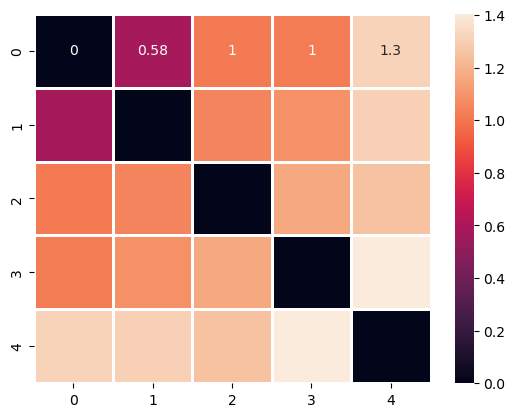

In [17]:
# Find the coordinates of each centroid using the cluster_centers_ attribute
centroids = kmeans.cluster_centers_

# Calculate the euclidean distance between the centroids
centroid_distances = pairwise_distances(centroids)

# Plot distances on heatmap
sns.heatmap(centroid_distances,
            annot=True,
            linewidths=1);

In [18]:
combined = pd.concat([df_general, scaled_df], axis=1)
combined.cluster.value_counts()
#combined#.loc[combined.cluster == 5]

cluster
3    1195
0    1001
1     995
2     772
4     770
Name: count, dtype: int64

In [19]:
scaled_df.groupby('cluster').agg(['mean'])#, 'std'])

danceability    energy       key  loudness      mode speechiness  \
                mean      mean      mean      mean      mean        mean   
cluster                                                                    
0           0.601950  0.704850  0.731995  0.860367  1.000000    0.342513   
1           0.612494  0.680151  0.156327  0.853395  1.000000    0.315166   
2           0.286997  0.899771  0.449246  0.843465  0.744819    0.498840   
3           0.631063  0.714625  0.555496  0.864022  0.000000    0.364700   
4           0.342455  0.137745  0.467178  0.636487  0.663636    0.239078   

        acousticness instrumentalness  liveness   valence     tempo  
                mean             mean      mean      mean      mean  
cluster                                                              
0           0.220034         0.033724  0.189520  0.556960  0.563557  
1           0.262251         0.033616  0.184695  0.590857  0.565529  
2           0.009674         0.790660  0.209253  0.246609  0.572398  
3           0.201009         0.081802  0.195397  0.529409  0.562345  
4           0.932968         0.694601  0.144070  0.180150  0.491005

/home/philip/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/philip/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/philip/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/philip/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

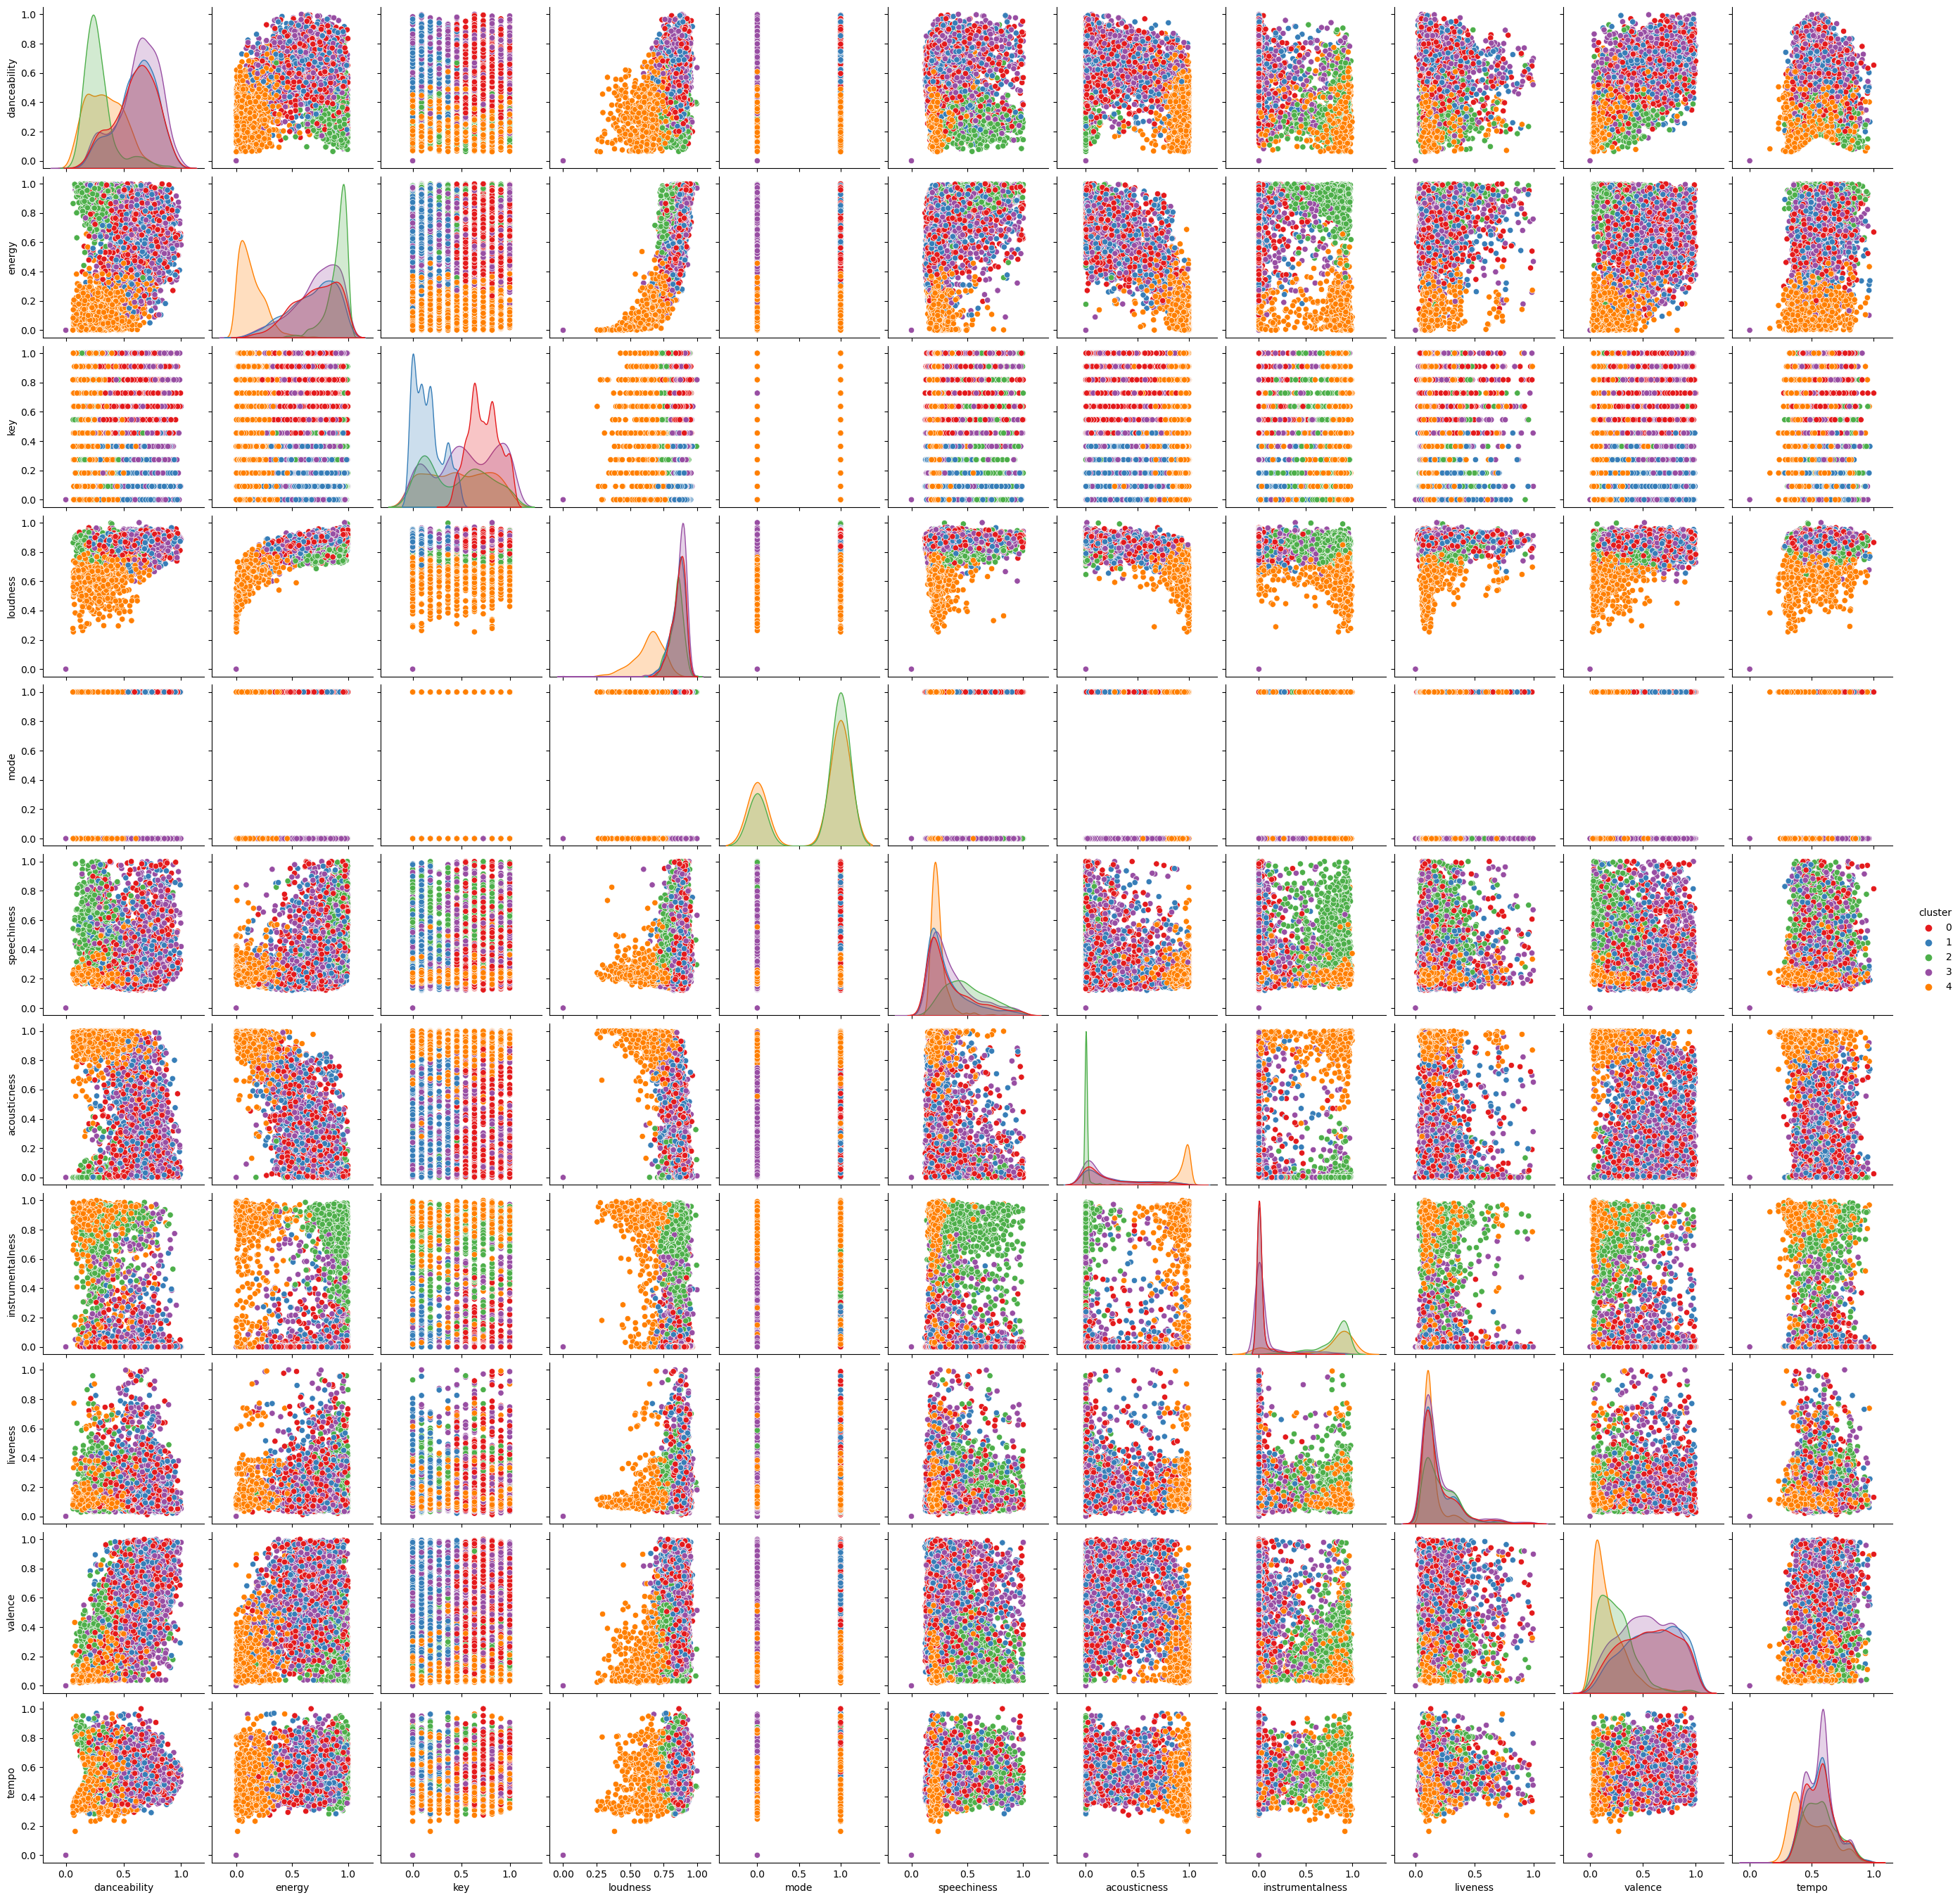

In [20]:
# turned off by default for better performance
#sns.pairplot(scaled_df, hue='cluster', palette='Set1')

# Define major clusters

From visual inspection of all parameter pairs, 4 parameters appear especially distinctive for cluster separation:

In [21]:
coarse_metrics = ['danceability', 'energy', 
           'acousticness', 'instrumentalness']

In [22]:
df_coarse = scaled_df.loc[:, scaled_df.columns.isin(coarse_metrics)].copy()
df_coarse.describe()

danceability       energy  acousticness  instrumentalness
count   4733.000000  4733.000000   4733.000000       4733.000000
mean       0.517929     0.641658      0.305779          0.276820
std        0.222358     0.294959      0.366433          0.382888
min        0.000000     0.000000      0.000000          0.000000
25%        0.314374     0.451000      0.002329          0.000002
50%        0.546019     0.729000      0.103414          0.003604
75%        0.698035     0.890000      0.625502          0.713706
max        1.000000     1.000000      1.000000          1.000000

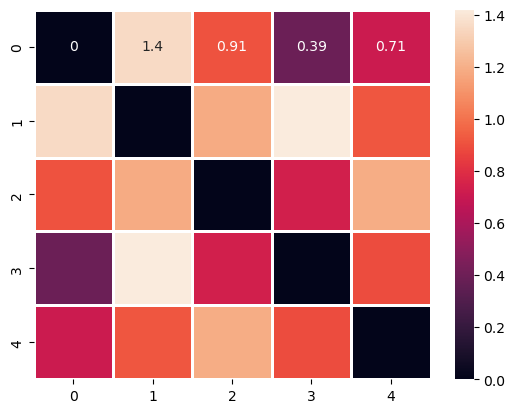

In [23]:
random_state = 101

# Initialise the model
kmeans = KMeans(n_clusters = 5, 
                n_init = "auto",
                random_state = random_state)

# Fit the model to the data
kmeans.fit(df_coarse)

# Obtain the cluster output
clusters = kmeans.labels_

# Attach the cluster output to our original DataFrame
df_coarse["cluster"] = clusters

# Find the coordinates of each centroid using the cluster_centers_ attribute
centroids = kmeans.cluster_centers_

# Calculate the euclidean distance between the centroids
centroid_distances = pairwise_distances(centroids)

# Plot distances on heatmap
sns.heatmap(centroid_distances,
            annot=True,
            linewidths=1);

/home/philip/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/philip/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/philip/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/philip/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

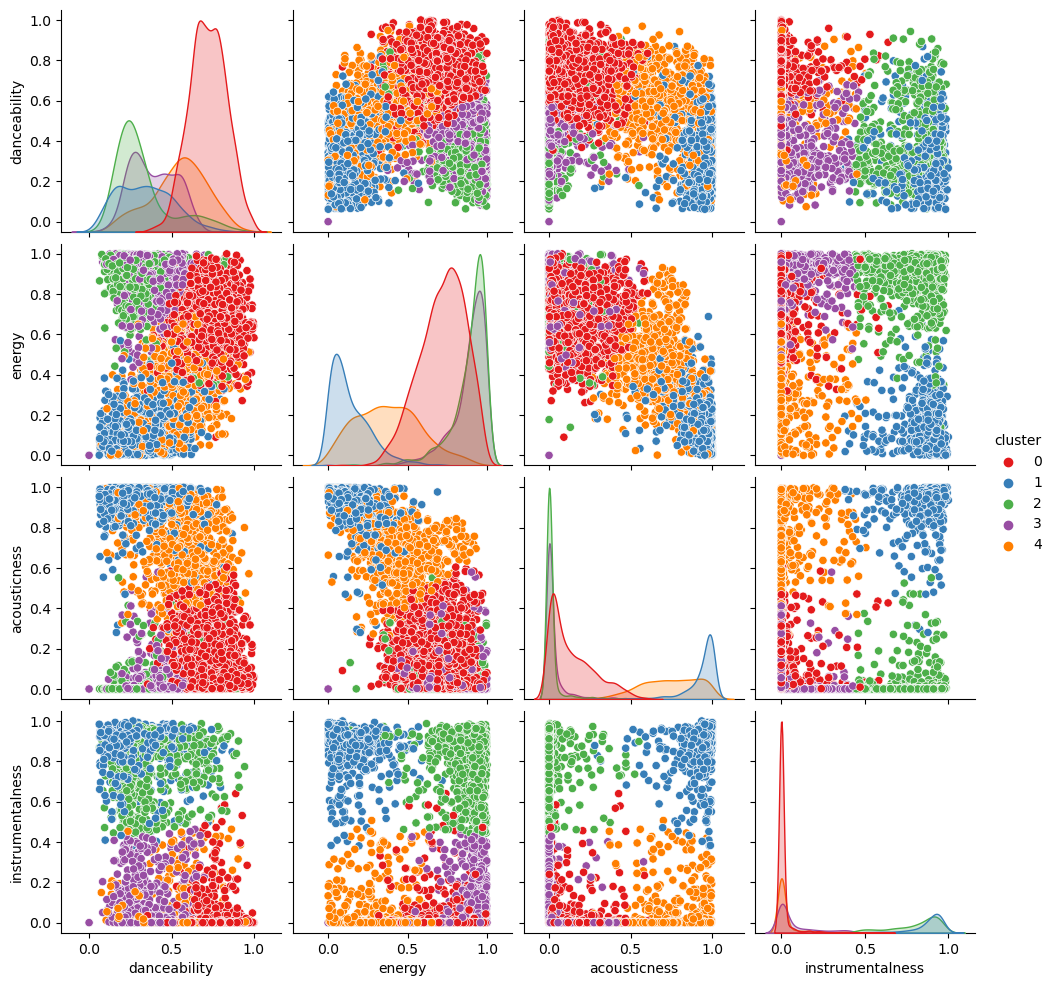

In [24]:
sns.pairplot(df_coarse, hue='cluster', palette='Set1')